In [1]:
# Cell 1: Setup and Imports
"""
Customer Segmentation Using Clustering with Optuna Optimization

This notebook demonstrates hyperparameter optimization for clustering algorithms
using Optuna framework on the Online Retail dataset.
"""

import sys
sys.path.insert(0, '/workspace')

from utils import *
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

print("Environment ready")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Optuna version: {optuna.__version__}")


Environment ready
Pandas version: 2.3.3
NumPy version: 2.2.6
Optuna version: 4.5.0


/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Cell 2: Load Data
"""
Load Online Retail dataset containing transaction records.
"""

df = load_data('online_retail.xlsx')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nData types:")
print(df.dtypes)
print(f"\nMissing values:")
print(df.isnull().sum())


Dataset shape: (541909, 8)

Columns: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']

First few rows:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  

Data types:
InvoiceNo      

In [3]:
# Cell 3: Data Cleaning
"""
Clean transaction data:
- Remove duplicates
- Filter service codes (non-product transactions)
- Remove invalid prices
- Cap outliers
- Filter to valid transactions only
"""

df_clean = clean_data(df)

print(f"\nCleaning Results:")
print(f"Original rows: {df.shape[0]:,}")
print(f"Cleaned rows: {df_clean.shape[0]:,}")
print(f"Removed: {df.shape[0] - df_clean.shape[0]:,} ({100*(df.shape[0]-df_clean.shape[0])/df.shape[0]:.1f}%)")
print(f"\nUnique customers: {df_clean['CustomerID'].nunique():,}")
print(f"Date range: {df_clean['InvoiceDate'].min()} to {df_clean['InvoiceDate'].max()}")
print(f"Total revenue: £{df_clean['Revenue'].sum():,.2f}")



Cleaning Results:
Original rows: 541,909
Cleaned rows: 388,561
Removed: 153,348 (28.3%)

Unique customers: 4,333
Date range: 2010-12-01 08:26:00 to 2011-12-09 12:50:00
Total revenue: £7,433,388.48


In [4]:
# Cell 4: Compute RFM Features
"""
RFM Analysis:
- Recency: Days since last purchase (lower = more recent)
- Frequency: Number of unique orders (higher = more loyal)
- Monetary: Total revenue contributed (higher = more valuable)

These 3 features capture customer value and engagement patterns.
"""

rfm = compute_rfm(df_clean)

print(f"RFM Features: {rfm.shape[0]:,} customers × {rfm.shape[1]} features")
print(f"\nRFM Statistics:")
print(rfm[['Recency', 'Frequency', 'Monetary']].describe())

print(f"\nDistribution checks:")
print(f"Recency range: {rfm['Recency'].min():.0f} - {rfm['Recency'].max():.0f} days")
print(f"Frequency range: {rfm['Frequency'].min():.0f} - {rfm['Frequency'].max():.0f} orders")
print(f"Monetary range: £{rfm['Monetary'].min():.2f} - £{rfm['Monetary'].max():.2f}")

RFM Features: 4,333 customers × 4 features

RFM Statistics:
           Recency    Frequency       Monetary
count  4333.000000  4333.000000    4333.000000
mean     92.723979     4.244403    1715.529305
std     100.179128     7.633759    5962.429132
min       1.000000     1.000000       3.750000
25%      18.000000     1.000000     290.400000
50%      51.000000     2.000000     641.920000
75%     143.000000     5.000000    1565.990000
max     374.000000   206.000000  209908.860000

Distribution checks:
Recency range: 1 - 374 days
Frequency range: 1 - 206 orders
Monetary range: £3.75 - £209908.86


In [5]:
# Cell 5: Feature Scaling
"""
Standardize RFM features using StandardScaler (z-score normalization).

Why StandardScaler:
- RFM features have different scales (days vs orders vs dollars)
- Clustering algorithms (especially K-Means, Hierarchical) are distance-based
- Without scaling, Monetary would dominate due to larger magnitude
- StandardScaler: mean=0, std=1 for each feature

Ensures equal weight for all three RFM dimensions.
"""

scaler = StandardScaler()
X = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

print(f"Scaled feature matrix: {X.shape}")
print(f"\nScaling verification:")
print(f"Mean per feature: {X.mean(axis=0)}")
print(f"Std per feature: {X.std(axis=0)}")
print(f"\nFirst 5 customers (scaled):")
print(X[:5])


Scaled feature matrix: (4333, 3)

Scaling verification:
Mean per feature: [ 8.93712880e-17 -3.27968029e-18  0.00000000e+00]
Std per feature: [1. 1. 1.]

First 5 customers (scaled):
[[ 2.3288578  -0.42505636 -0.27031186]
 [-0.90572209  0.36101671  0.4044994 ]
 [-0.17694329 -0.03201982 -0.06935043]
 [-0.73600648 -0.42505636 -0.04718409]
 [ 2.16912546 -0.42505636 -0.23837488]]


In [6]:
# Cell 5.5: Handle Extreme Outliers
"""
Problem: Extreme outliers (£200K customers) cause degenerate clusters.
Solution: Remove top outliers using z-score threshold.

Z-score > 3 indicates extreme outliers (beyond 99.7th percentile).
"""

from scipy.stats import zscore

# Calculate z-scores
z_scores = np.abs(zscore(X, axis=0))
outlier_mask = (z_scores > 3).any(axis=1)
n_outliers = outlier_mask.sum()

print(f"Extreme outliers detected: {n_outliers} ({100*n_outliers/len(X):.2f}%)")
print(f"\nOutlier customers (z-score > 3):")
print(rfm[outlier_mask][['Recency', 'Frequency', 'Monetary']].describe())

# Create clean dataset
X_clean = X[~outlier_mask]
rfm_clean = rfm[~outlier_mask].reset_index(drop=True)

print(f"\nCleaned dataset: {X_clean.shape[0]:,} customers (removed {n_outliers})")
print(f"Ready for optimization.")


Extreme outliers detected: 60 (1.38%)

Outlier customers (z-score > 3):
          Recency   Frequency       Monetary
count   60.000000   60.000000      60.000000
mean    12.633333   46.633333   32721.239000
std     47.775948   36.330856   37060.816405
min      1.000000    6.000000    1173.980000
25%      1.750000   29.750000    9974.155000
50%      4.000000   35.000000   19878.990000
75%      9.000000   50.250000   39804.067500
max    372.000000  206.000000  209908.860000

Cleaned dataset: 4,273 customers (removed 60)
Ready for optimization.


In [7]:
# Cell 6: Optimize K-Means with Optuna
"""
K-Means Optimization:

Hyperparameters:
- n_clusters: [3, 8] - business typically needs 3-8 segments
- init: ['k-means++', 'random'] - initialization strategy
- n_init: [10, 30] - number of random restarts for stability

Objective: Multi-objective composite score
- 50% Silhouette (cluster separation)
- 30% Davies-Bouldin inverse (cluster compactness)
- 20% Balance (avoid one dominant cluster)

Pruning: MedianPruner stops poor trials early (saves compute)
"""
print("Running K-Means optimization on clean data (100 trials)...")
study_kmeans = optimize_kmeans(X_clean, n_trials=100)

print(f"\nBest silhouette: {study_kmeans.best_value:.4f}")
print(f"Best parameters: {study_kmeans.best_params}")


[I 2025-12-14 10:58:43,611] A new study created in memory with name: no-name-e6b865e7-066a-411c-b879-53646a9e86f8


Running K-Means optimization on clean data (100 trials)...


Best trial: 0. Best value: 0.449487:   1%|          | 1/100 [00:00<01:20,  1.23it/s]

[I 2025-12-14 10:58:44,429] Trial 0 finished with value: 0.44948711748680037 and parameters: {'n_clusters': 5, 'init': 'k-means++', 'n_init': 22}. Best is trial 0 with value: 0.44948711748680037.


Best trial: 1. Best value: 0.559776:   2%|▏         | 2/100 [00:01<01:08,  1.43it/s]

[I 2025-12-14 10:58:45,050] Trial 1 finished with value: 0.5597757940597526 and parameters: {'n_clusters': 3, 'init': 'k-means++', 'n_init': 28}. Best is trial 1 with value: 0.5597757940597526.


Best trial: 1. Best value: 0.559776:   3%|▎         | 3/100 [00:02<01:11,  1.36it/s]

[I 2025-12-14 10:58:45,826] Trial 2 finished with value: 0.4210299258569317 and parameters: {'n_clusters': 6, 'init': 'k-means++', 'n_init': 30}. Best is trial 1 with value: 0.5597757940597526.


Best trial: 1. Best value: 0.559776:   4%|▍         | 4/100 [00:02<00:59,  1.62it/s]

[I 2025-12-14 10:58:46,264] Trial 3 finished with value: 0.4072103997976519 and parameters: {'n_clusters': 7, 'init': 'k-means++', 'n_init': 13}. Best is trial 1 with value: 0.5597757940597526.


Best trial: 1. Best value: 0.559776:   5%|▌         | 5/100 [00:03<00:57,  1.65it/s]

[I 2025-12-14 10:58:46,848] Trial 4 finished with value: 0.5136349826951444 and parameters: {'n_clusters': 4, 'init': 'k-means++', 'n_init': 16}. Best is trial 1 with value: 0.5597757940597526.


Best trial: 1. Best value: 0.559776:   6%|▌         | 6/100 [00:03<00:58,  1.59it/s]

[I 2025-12-14 10:58:47,518] Trial 5 finished with value: 0.4209763864124731 and parameters: {'n_clusters': 6, 'init': 'random', 'n_init': 17}. Best is trial 1 with value: 0.5597757940597526.


Best trial: 1. Best value: 0.559776:   7%|▋         | 7/100 [00:04<00:54,  1.70it/s]

[I 2025-12-14 10:58:48,025] Trial 6 finished with value: 0.44948711748680037 and parameters: {'n_clusters': 5, 'init': 'k-means++', 'n_init': 20}. Best is trial 1 with value: 0.5597757940597526.


Best trial: 1. Best value: 0.559776:   8%|▊         | 8/100 [00:05<00:57,  1.61it/s]

[I 2025-12-14 10:58:48,718] Trial 7 finished with value: 0.4209763864124731 and parameters: {'n_clusters': 6, 'init': 'random', 'n_init': 13}. Best is trial 1 with value: 0.5597757940597526.


Best trial: 8. Best value: 0.560065:   9%|▉         | 9/100 [00:05<00:57,  1.59it/s]

[I 2025-12-14 10:58:49,362] Trial 8 finished with value: 0.5600648329251535 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 26}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  10%|█         | 10/100 [00:06<00:54,  1.64it/s]

[I 2025-12-14 10:58:49,929] Trial 9 finished with value: 0.5134320050664912 and parameters: {'n_clusters': 4, 'init': 'random', 'n_init': 19}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  11%|█         | 11/100 [00:07<00:59,  1.50it/s]

[I 2025-12-14 10:58:50,729] Trial 10 finished with value: 0.39919188524353355 and parameters: {'n_clusters': 8, 'init': 'random', 'n_init': 24}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  12%|█▏        | 12/100 [00:07<00:56,  1.56it/s]

[I 2025-12-14 10:58:51,307] Trial 11 finished with value: 0.5600648329251535 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 28}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  13%|█▎        | 13/100 [00:08<00:58,  1.49it/s]

[I 2025-12-14 10:58:52,042] Trial 12 finished with value: 0.5600648329251535 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 26}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  14%|█▍        | 14/100 [00:08<00:54,  1.59it/s]

[I 2025-12-14 10:58:52,582] Trial 13 finished with value: 0.5600648329251535 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 26}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  15%|█▌        | 15/100 [00:09<00:56,  1.49it/s]

[I 2025-12-14 10:58:53,347] Trial 14 finished with value: 0.5134320050664912 and parameters: {'n_clusters': 4, 'init': 'random', 'n_init': 30}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  16%|█▌        | 16/100 [00:10<00:52,  1.59it/s]

[I 2025-12-14 10:58:53,878] Trial 15 finished with value: 0.5600648329251535 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 24}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  17%|█▋        | 17/100 [00:10<00:53,  1.55it/s]

[I 2025-12-14 10:58:54,564] Trial 16 finished with value: 0.5134320050664912 and parameters: {'n_clusters': 4, 'init': 'random', 'n_init': 27}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  18%|█▊        | 18/100 [00:11<00:51,  1.59it/s]

[I 2025-12-14 10:58:55,154] Trial 17 finished with value: 0.44948711748680037 and parameters: {'n_clusters': 5, 'init': 'random', 'n_init': 23}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  19%|█▉        | 19/100 [00:12<00:49,  1.64it/s]

[I 2025-12-14 10:58:55,719] Trial 18 finished with value: 0.5600648329251535 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 28}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  20%|██        | 20/100 [00:12<00:49,  1.62it/s]

[I 2025-12-14 10:58:56,355] Trial 19 finished with value: 0.5134320050664912 and parameters: {'n_clusters': 4, 'init': 'random', 'n_init': 22}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  21%|██        | 21/100 [00:13<00:44,  1.77it/s]

[I 2025-12-14 10:58:56,795] Trial 20 finished with value: 0.39827781575552224 and parameters: {'n_clusters': 8, 'init': 'random', 'n_init': 10}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  22%|██▏       | 22/100 [00:13<00:43,  1.79it/s]

[I 2025-12-14 10:58:57,338] Trial 21 finished with value: 0.5600648329251535 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 26}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  23%|██▎       | 23/100 [00:14<00:42,  1.83it/s]

[I 2025-12-14 10:58:57,859] Trial 22 finished with value: 0.5600648329251535 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 25}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  24%|██▍       | 24/100 [00:14<00:45,  1.66it/s]

[I 2025-12-14 10:58:58,590] Trial 23 finished with value: 0.5134320050664912 and parameters: {'n_clusters': 4, 'init': 'random', 'n_init': 29}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  25%|██▌       | 25/100 [00:15<00:45,  1.65it/s]

[I 2025-12-14 10:58:59,203] Trial 24 finished with value: 0.5600648329251535 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 27}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  26%|██▌       | 26/100 [00:16<00:44,  1.66it/s]

[I 2025-12-14 10:58:59,800] Trial 25 finished with value: 0.5134320050664912 and parameters: {'n_clusters': 4, 'init': 'random', 'n_init': 20}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  27%|██▋       | 27/100 [00:16<00:43,  1.69it/s]

[I 2025-12-14 10:59:00,362] Trial 26 finished with value: 0.5600648329251535 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 25}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  28%|██▊       | 28/100 [00:17<00:44,  1.63it/s]

[I 2025-12-14 10:59:01,025] Trial 27 finished with value: 0.44948711748680037 and parameters: {'n_clusters': 5, 'init': 'random', 'n_init': 28}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  29%|██▉       | 29/100 [00:18<00:50,  1.42it/s]

[I 2025-12-14 10:59:01,943] Trial 28 finished with value: 0.4072058269465233 and parameters: {'n_clusters': 7, 'init': 'random', 'n_init': 30}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  30%|███       | 30/100 [00:18<00:46,  1.49it/s]

[I 2025-12-14 10:59:02,535] Trial 29 finished with value: 0.44948711748680037 and parameters: {'n_clusters': 5, 'init': 'k-means++', 'n_init': 22}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  31%|███       | 31/100 [00:19<00:43,  1.59it/s]

[I 2025-12-14 10:59:03,072] Trial 30 finished with value: 0.5600648329251535 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 23}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  32%|███▏      | 32/100 [00:20<00:42,  1.61it/s]

[I 2025-12-14 10:59:03,669] Trial 31 finished with value: 0.5600648329251535 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 26}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  33%|███▎      | 33/100 [00:20<00:40,  1.66it/s]

[I 2025-12-14 10:59:04,225] Trial 32 finished with value: 0.5600648329251535 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 26}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  34%|███▍      | 34/100 [00:21<00:41,  1.57it/s]

[I 2025-12-14 10:59:04,942] Trial 33 finished with value: 0.5134320050664912 and parameters: {'n_clusters': 4, 'init': 'random', 'n_init': 28}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  35%|███▌      | 35/100 [00:21<00:39,  1.64it/s]

[I 2025-12-14 10:59:05,492] Trial 34 finished with value: 0.5597757940597526 and parameters: {'n_clusters': 3, 'init': 'k-means++', 'n_init': 27}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  36%|███▌      | 36/100 [00:22<00:37,  1.70it/s]

[I 2025-12-14 10:59:06,032] Trial 35 finished with value: 0.5597757940597526 and parameters: {'n_clusters': 3, 'init': 'k-means++', 'n_init': 29}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  37%|███▋      | 37/100 [00:23<00:38,  1.63it/s]

[I 2025-12-14 10:59:06,700] Trial 36 finished with value: 0.5134320050664912 and parameters: {'n_clusters': 4, 'init': 'random', 'n_init': 25}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  38%|███▊      | 38/100 [00:23<00:36,  1.72it/s]

[I 2025-12-14 10:59:07,213] Trial 37 finished with value: 0.5597757940597526 and parameters: {'n_clusters': 3, 'init': 'k-means++', 'n_init': 24}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  39%|███▉      | 39/100 [00:24<00:37,  1.63it/s]

[I 2025-12-14 10:59:07,903] Trial 38 finished with value: 0.4069440646581943 and parameters: {'n_clusters': 7, 'init': 'random', 'n_init': 21}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  40%|████      | 40/100 [00:24<00:36,  1.67it/s]

[I 2025-12-14 10:59:08,468] Trial 39 finished with value: 0.5134320050664912 and parameters: {'n_clusters': 4, 'init': 'random', 'n_init': 19}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  41%|████      | 41/100 [00:25<00:35,  1.67it/s]

[I 2025-12-14 10:59:09,069] Trial 40 finished with value: 0.44948711748680037 and parameters: {'n_clusters': 5, 'init': 'k-means++', 'n_init': 29}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  42%|████▏     | 42/100 [00:26<00:37,  1.53it/s]

[I 2025-12-14 10:59:09,840] Trial 41 finished with value: 0.5600648329251535 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 26}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  43%|████▎     | 43/100 [00:26<00:34,  1.63it/s]

[I 2025-12-14 10:59:10,363] Trial 42 finished with value: 0.5600648329251535 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 24}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  44%|████▍     | 44/100 [00:27<00:34,  1.63it/s]

[I 2025-12-14 10:59:10,975] Trial 43 finished with value: 0.5600648329251535 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 27}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  45%|████▌     | 45/100 [00:28<00:34,  1.59it/s]

[I 2025-12-14 10:59:11,640] Trial 44 finished with value: 0.5134320050664912 and parameters: {'n_clusters': 4, 'init': 'random', 'n_init': 23}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  46%|████▌     | 46/100 [00:28<00:33,  1.61it/s]

[I 2025-12-14 10:59:12,251] Trial 45 finished with value: 0.5600648329251535 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 25}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  47%|████▋     | 47/100 [00:29<00:32,  1.63it/s]

[I 2025-12-14 10:59:12,845] Trial 46 finished with value: 0.5134320050664912 and parameters: {'n_clusters': 4, 'init': 'random', 'n_init': 17}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  48%|████▊     | 48/100 [00:29<00:32,  1.58it/s]

[I 2025-12-14 10:59:13,515] Trial 47 finished with value: 0.5600648329251535 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 30}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  49%|████▉     | 49/100 [00:30<00:34,  1.48it/s]

[I 2025-12-14 10:59:14,298] Trial 48 finished with value: 0.4211283686602329 and parameters: {'n_clusters': 6, 'init': 'random', 'n_init': 24}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  50%|█████     | 50/100 [00:31<00:35,  1.41it/s]

[I 2025-12-14 10:59:15,082] Trial 49 finished with value: 0.5134320050664912 and parameters: {'n_clusters': 4, 'init': 'random', 'n_init': 28}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  51%|█████     | 51/100 [00:32<00:32,  1.50it/s]

[I 2025-12-14 10:59:15,647] Trial 50 finished with value: 0.5600648329251535 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 27}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  52%|█████▏    | 52/100 [00:32<00:30,  1.56it/s]

[I 2025-12-14 10:59:16,234] Trial 51 finished with value: 0.5600648329251535 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 28}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  53%|█████▎    | 53/100 [00:33<00:29,  1.57it/s]

[I 2025-12-14 10:59:16,853] Trial 52 finished with value: 0.5600648329251535 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 29}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  54%|█████▍    | 54/100 [00:33<00:28,  1.63it/s]

[I 2025-12-14 10:59:17,418] Trial 53 finished with value: 0.5600648329251535 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 26}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  55%|█████▌    | 55/100 [00:34<00:28,  1.57it/s]

[I 2025-12-14 10:59:18,113] Trial 54 finished with value: 0.5134320050664912 and parameters: {'n_clusters': 4, 'init': 'random', 'n_init': 28}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  56%|█████▌    | 56/100 [00:35<00:27,  1.62it/s]

[I 2025-12-14 10:59:18,685] Trial 55 finished with value: 0.5600648329251535 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 25}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  57%|█████▋    | 57/100 [00:35<00:26,  1.64it/s]

[I 2025-12-14 10:59:19,277] Trial 56 finished with value: 0.5600648329251535 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 27}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  58%|█████▊    | 58/100 [00:36<00:27,  1.54it/s]

[I 2025-12-14 10:59:20,010] Trial 57 finished with value: 0.5134320050664912 and parameters: {'n_clusters': 4, 'init': 'random', 'n_init': 29}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  59%|█████▉    | 59/100 [00:37<00:26,  1.55it/s]

[I 2025-12-14 10:59:20,648] Trial 58 finished with value: 0.5597757940597526 and parameters: {'n_clusters': 3, 'init': 'k-means++', 'n_init': 22}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  60%|██████    | 60/100 [00:37<00:26,  1.49it/s]

[I 2025-12-14 10:59:21,376] Trial 59 finished with value: 0.5134320050664912 and parameters: {'n_clusters': 4, 'init': 'random', 'n_init': 24}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  61%|██████    | 61/100 [00:38<00:30,  1.26it/s]

[I 2025-12-14 10:59:22,457] Trial 60 finished with value: 0.39919188524353355 and parameters: {'n_clusters': 8, 'init': 'random', 'n_init': 26}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  62%|██████▏   | 62/100 [00:39<00:26,  1.45it/s]

[I 2025-12-14 10:59:22,900] Trial 61 finished with value: 0.5600648329251535 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 15}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  63%|██████▎   | 63/100 [00:40<00:26,  1.38it/s]

[I 2025-12-14 10:59:23,704] Trial 62 finished with value: 0.5600648329251535 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 26}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  64%|██████▍   | 64/100 [00:40<00:24,  1.50it/s]

[I 2025-12-14 10:59:24,247] Trial 63 finished with value: 0.5600648329251535 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 25}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  65%|██████▌   | 65/100 [00:41<00:22,  1.56it/s]

[I 2025-12-14 10:59:24,825] Trial 64 finished with value: 0.5600648329251535 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 27}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  66%|██████▌   | 66/100 [00:41<00:20,  1.65it/s]

[I 2025-12-14 10:59:25,348] Trial 65 finished with value: 0.5600648329251535 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 23}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  67%|██████▋   | 67/100 [00:42<00:19,  1.66it/s]

[I 2025-12-14 10:59:25,939] Trial 66 finished with value: 0.5600648329251535 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 28}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  68%|██████▊   | 68/100 [00:43<00:22,  1.44it/s]

[I 2025-12-14 10:59:26,852] Trial 67 finished with value: 0.4211283686602329 and parameters: {'n_clusters': 6, 'init': 'random', 'n_init': 30}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  69%|██████▉   | 69/100 [00:43<00:20,  1.51it/s]

[I 2025-12-14 10:59:27,442] Trial 68 finished with value: 0.5136349826951444 and parameters: {'n_clusters': 4, 'init': 'k-means++', 'n_init': 27}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  70%|███████   | 70/100 [00:44<00:18,  1.61it/s]

[I 2025-12-14 10:59:27,966] Trial 69 finished with value: 0.5600648329251535 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 21}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  71%|███████   | 71/100 [00:44<00:17,  1.63it/s]

[I 2025-12-14 10:59:28,552] Trial 70 finished with value: 0.5600648329251535 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 26}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  72%|███████▏  | 72/100 [00:45<00:17,  1.62it/s]

[I 2025-12-14 10:59:29,177] Trial 71 finished with value: 0.5600648329251535 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 25}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  73%|███████▎  | 73/100 [00:45<00:14,  1.85it/s]

[I 2025-12-14 10:59:29,547] Trial 72 finished with value: 0.5600648329251535 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 10}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  74%|███████▍  | 74/100 [00:46<00:14,  1.82it/s]

[I 2025-12-14 10:59:30,123] Trial 73 finished with value: 0.5600648329251535 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 25}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  75%|███████▌  | 75/100 [00:47<00:15,  1.65it/s]

[I 2025-12-14 10:59:30,863] Trial 74 finished with value: 0.4069440646581943 and parameters: {'n_clusters': 7, 'init': 'random', 'n_init': 24}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  76%|███████▌  | 76/100 [00:47<00:14,  1.65it/s]

[I 2025-12-14 10:59:31,459] Trial 75 finished with value: 0.5600648329251535 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 29}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  77%|███████▋  | 77/100 [00:48<00:14,  1.57it/s]

[I 2025-12-14 10:59:32,167] Trial 76 finished with value: 0.5134320050664912 and parameters: {'n_clusters': 4, 'init': 'random', 'n_init': 26}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  78%|███████▊  | 78/100 [00:49<00:13,  1.60it/s]

[I 2025-12-14 10:59:32,774] Trial 77 finished with value: 0.5600648329251535 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 28}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  79%|███████▉  | 79/100 [00:49<00:13,  1.59it/s]

[I 2025-12-14 10:59:33,403] Trial 78 finished with value: 0.5136349826951444 and parameters: {'n_clusters': 4, 'init': 'k-means++', 'n_init': 27}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  80%|████████  | 80/100 [00:50<00:12,  1.65it/s]

[I 2025-12-14 10:59:33,963] Trial 79 finished with value: 0.5600648329251535 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 25}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  81%|████████  | 81/100 [00:50<00:10,  1.85it/s]

[I 2025-12-14 10:59:34,346] Trial 80 finished with value: 0.5600648329251535 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 12}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  82%|████████▏ | 82/100 [00:51<00:09,  1.85it/s]

[I 2025-12-14 10:59:34,891] Trial 81 finished with value: 0.5600648329251535 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 26}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  83%|████████▎ | 83/100 [00:51<00:09,  1.81it/s]

[I 2025-12-14 10:59:35,467] Trial 82 finished with value: 0.5600648329251535 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 27}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  84%|████████▍ | 84/100 [00:52<00:09,  1.77it/s]

[I 2025-12-14 10:59:36,063] Trial 83 finished with value: 0.5600648329251535 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 28}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  85%|████████▌ | 85/100 [00:52<00:08,  1.81it/s]

[I 2025-12-14 10:59:36,586] Trial 84 finished with value: 0.5600648329251535 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 24}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  86%|████████▌ | 86/100 [00:53<00:07,  1.78it/s]

[I 2025-12-14 10:59:37,174] Trial 85 finished with value: 0.5600648329251535 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 27}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  87%|████████▋ | 87/100 [00:54<00:07,  1.83it/s]

[I 2025-12-14 10:59:37,678] Trial 86 finished with value: 0.5600648329251535 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 23}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  88%|████████▊ | 88/100 [00:54<00:06,  1.79it/s]

[I 2025-12-14 10:59:38,267] Trial 87 finished with value: 0.5600648329251535 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 29}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  89%|████████▉ | 89/100 [00:55<00:06,  1.70it/s]

[I 2025-12-14 10:59:38,918] Trial 88 finished with value: 0.5134320050664912 and parameters: {'n_clusters': 4, 'init': 'random', 'n_init': 25}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  90%|█████████ | 90/100 [00:56<00:06,  1.51it/s]

[I 2025-12-14 10:59:39,750] Trial 89 finished with value: 0.5597757940597526 and parameters: {'n_clusters': 3, 'init': 'k-means++', 'n_init': 26}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  91%|█████████ | 91/100 [00:56<00:06,  1.44it/s]

[I 2025-12-14 10:59:40,518] Trial 90 finished with value: 0.5134320050664912 and parameters: {'n_clusters': 4, 'init': 'random', 'n_init': 30}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  92%|█████████▏| 92/100 [00:57<00:05,  1.54it/s]

[I 2025-12-14 10:59:41,073] Trial 91 finished with value: 0.5600648329251535 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 25}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  93%|█████████▎| 93/100 [00:58<00:04,  1.55it/s]

[I 2025-12-14 10:59:41,711] Trial 92 finished with value: 0.5600648329251535 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 28}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  94%|█████████▍| 94/100 [00:58<00:03,  1.54it/s]

[I 2025-12-14 10:59:42,366] Trial 93 finished with value: 0.5600648329251535 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 26}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  95%|█████████▌| 95/100 [00:59<00:03,  1.47it/s]

[I 2025-12-14 10:59:43,117] Trial 94 finished with value: 0.5600648329251535 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 27}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  96%|█████████▌| 96/100 [01:00<00:02,  1.51it/s]

[I 2025-12-14 10:59:43,738] Trial 95 finished with value: 0.5600648329251535 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 24}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  97%|█████████▋| 97/100 [01:00<00:01,  1.64it/s]

[I 2025-12-14 10:59:44,233] Trial 96 finished with value: 0.5600648329251535 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 23}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  98%|█████████▊| 98/100 [01:01<00:01,  1.62it/s]

[I 2025-12-14 10:59:44,868] Trial 97 finished with value: 0.5600648329251535 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 28}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065:  99%|█████████▉| 99/100 [01:01<00:00,  1.73it/s]

[I 2025-12-14 10:59:45,353] Trial 98 finished with value: 0.5600648329251535 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 22}. Best is trial 8 with value: 0.5600648329251535.


Best trial: 8. Best value: 0.560065: 100%|██████████| 100/100 [01:02<00:00,  1.61it/s]

[I 2025-12-14 10:59:45,893] Trial 99 finished with value: 0.5600648329251535 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 26}. Best is trial 8 with value: 0.5600648329251535.

Best silhouette: 0.5601
Best parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 26}


In [8]:
# Cell 7 (REVISED): Optimize DBSCAN with Detailed Reporting
"""
Optimize DBSCAN hyperparameters.
Track pruning to detect if algorithm is unsuitable for data.
"""

print("Running DBSCAN optimization on clean data (50 trials)...")
study_dbscan = optimize_dbscan(X_clean, n_trials=50)

# Check results
completed_trials = [t for t in study_dbscan.trials if t.state == optuna.trial.TrialState.COMPLETE]
pruned_trials = [t for t in study_dbscan.trials if t.state == optuna.trial.TrialState.PRUNED]

print(f"\nCompleted trials: {len(completed_trials)}")
print(f"Pruned trials: {len(pruned_trials)}")

if len(completed_trials) == 0:
    print("DBSCAN UNSUITABLE FOR THIS DATASET")
    print(f"All {len(pruned_trials)} trials were pruned.")
    print("\nReasons for pruning:")
    print("  • Unable to find eps/min_samples producing ≥2 valid clusters")
    print("  • All configurations resulted in >50% noise points")
    print("\nRoot cause: RFM data has highly variable cluster densities")
    print("(VIP: tight/dense, At-Risk: sparse/scattered, Loyal: large/medium)")
    print("\nDBSCAN requires constant density across clusters [limitation]")
    print("\nNote: Initial tests (before outlier removal) also produced")
    print("degenerate clustering (4308 vs 3 customer split).")
else:
    print(f"\nBest silhouette: {study_dbscan.best_value:.4f}")
    print(f"Best parameters: {study_dbscan.best_params}")



[I 2025-12-14 10:59:45,912] A new study created in memory with name: no-name-28ec501f-e3f2-49a9-86c3-100cbdf5b0a3


Running DBSCAN optimization on clean data (50 trials)...


  2%|▏         | 1/50 [00:00<00:06,  7.17it/s]

[I 2025-12-14 10:59:46,052] Trial 0 pruned. 


  6%|▌         | 3/50 [00:00<00:04, 10.08it/s]

[I 2025-12-14 10:59:46,144] Trial 1 pruned. 
[I 2025-12-14 10:59:46,222] Trial 2 pruned. 


  6%|▌         | 3/50 [00:00<00:04, 10.08it/s]

[I 2025-12-14 10:59:46,290] Trial 3 pruned. 


 10%|█         | 5/50 [00:00<00:04, 10.98it/s]

[I 2025-12-14 10:59:46,387] Trial 4 pruned. 
[I 2025-12-14 10:59:46,451] Trial 5 pruned. 


 14%|█▍        | 7/50 [00:00<00:03, 11.74it/s]

[I 2025-12-14 10:59:46,543] Trial 6 pruned. 


 18%|█▊        | 9/50 [00:00<00:03, 11.56it/s]

[I 2025-12-14 10:59:46,633] Trial 7 pruned. 
[I 2025-12-14 10:59:46,721] Trial 8 pruned. 


 22%|██▏       | 11/50 [00:01<00:03, 10.75it/s]

[I 2025-12-14 10:59:46,838] Trial 9 pruned. 
[I 2025-12-14 10:59:46,931] Trial 10 pruned. 
[I 2025-12-14 10:59:47,023] Trial 11 pruned. 


 30%|███       | 15/50 [00:01<00:03, 10.96it/s]

[I 2025-12-14 10:59:47,108] Trial 12 pruned. 
[I 2025-12-14 10:59:47,202] Trial 13 pruned. 
[I 2025-12-14 10:59:47,290] Trial 14 pruned. 


 34%|███▍      | 17/50 [00:01<00:03, 10.94it/s]

[I 2025-12-14 10:59:47,377] Trial 15 pruned. 
[I 2025-12-14 10:59:47,474] Trial 16 pruned. 
[I 2025-12-14 10:59:47,563] Trial 17 pruned. 


 42%|████▏     | 21/50 [00:01<00:02, 10.93it/s]

[I 2025-12-14 10:59:47,656] Trial 18 pruned. 
[I 2025-12-14 10:59:47,750] Trial 19 pruned. 
[I 2025-12-14 10:59:47,840] Trial 20 pruned. 


 46%|████▌     | 23/50 [00:02<00:02, 11.44it/s]

[I 2025-12-14 10:59:47,921] Trial 21 pruned. 
[I 2025-12-14 10:59:47,996] Trial 22 pruned. 
[I 2025-12-14 10:59:48,080] Trial 23 pruned. 


 54%|█████▍    | 27/50 [00:02<00:02, 11.45it/s]

[I 2025-12-14 10:59:48,170] Trial 24 pruned. 
[I 2025-12-14 10:59:48,253] Trial 25 pruned. 
[I 2025-12-14 10:59:48,345] Trial 26 pruned. 


 58%|█████▊    | 29/50 [00:02<00:02,  9.39it/s]

[I 2025-12-14 10:59:48,517] Trial 27 pruned. 
[I 2025-12-14 10:59:48,647] Trial 28 pruned. 
[I 2025-12-14 10:59:48,720] Trial 29 pruned. 


 66%|██████▌   | 33/50 [00:03<00:01, 11.02it/s]

[I 2025-12-14 10:59:48,814] Trial 30 pruned. 
[I 2025-12-14 10:59:48,877] Trial 31 pruned. 
[I 2025-12-14 10:59:48,955] Trial 32 pruned. 


 70%|███████   | 35/50 [00:03<00:01, 11.61it/s]

[I 2025-12-14 10:59:49,018] Trial 33 pruned. 
[I 2025-12-14 10:59:49,105] Trial 34 pruned. 
[I 2025-12-14 10:59:49,190] Trial 35 pruned. 


 78%|███████▊  | 39/50 [00:03<00:00, 11.71it/s]

[I 2025-12-14 10:59:49,277] Trial 36 pruned. 
[I 2025-12-14 10:59:49,353] Trial 37 pruned. 
[I 2025-12-14 10:59:49,445] Trial 38 pruned. 


 82%|████████▏ | 41/50 [00:03<00:00, 11.51it/s]

[I 2025-12-14 10:59:49,529] Trial 39 pruned. 
[I 2025-12-14 10:59:49,626] Trial 40 pruned. 
[I 2025-12-14 10:59:49,720] Trial 41 pruned. 


 90%|█████████ | 45/50 [00:04<00:00, 11.24it/s]

[I 2025-12-14 10:59:49,807] Trial 42 pruned. 
[I 2025-12-14 10:59:49,899] Trial 43 pruned. 
[I 2025-12-14 10:59:49,988] Trial 44 pruned. 


 94%|█████████▍| 47/50 [00:04<00:00, 11.15it/s]

[I 2025-12-14 10:59:50,082] Trial 45 pruned. 
[I 2025-12-14 10:59:50,172] Trial 46 pruned. 
[I 2025-12-14 10:59:50,263] Trial 47 pruned. 


100%|██████████| 50/50 [00:04<00:00, 11.03it/s]

[I 2025-12-14 10:59:50,359] Trial 48 pruned. 
[I 2025-12-14 10:59:50,447] Trial 49 pruned. 

Completed trials: 0
Pruned trials: 50
DBSCAN UNSUITABLE FOR THIS DATASET
All 50 trials were pruned.

Reasons for pruning:
  • Unable to find eps/min_samples producing ≥2 valid clusters
  • All configurations resulted in >50% noise points

Root cause: RFM data has highly variable cluster densities
(VIP: tight/dense, At-Risk: sparse/scattered, Loyal: large/medium)

DBSCAN requires constant density across clusters [limitation]

Note: Initial tests (before outlier removal) also produced
degenerate clustering (4308 vs 3 customer split).


In [9]:
 # Cell 8: Optimize Hierarchical with Optuna
"""
Hierarchical Clustering Optimization:

Hierarchical builds a dendrogram by merging clusters bottom-up.

Hyperparameters:
- n_clusters: Where to cut dendrogram (3-8)
- linkage: Distance metric between clusters
  - ward: Minimize variance (best for K-Means-like data)
  - complete: Minimize max distance (compact clusters)
  - average: Balance between ward and complete

Advantage: Deterministic (no random restarts needed)
"""

print("Running Hierarchical optimization on clean data (100 trials)...")
study_hc = optimize_hierarchical(X_clean, n_trials=100)

print(f"\nBest silhouette: {study_hc.best_value:.4f}")
print(f"Best parameters: {study_hc.best_params}")

[I 2025-12-14 10:59:50,461] A new study created in memory with name: no-name-2673c272-e4d0-41e7-b72d-d7c663ccd948


Running Hierarchical optimization on clean data (100 trials)...


Best trial: 0. Best value: 0.391801:   1%|          | 1/100 [00:00<00:52,  1.88it/s]

[I 2025-12-14 10:59:50,994] Trial 0 finished with value: 0.3918013043719732 and parameters: {'n_clusters': 5, 'linkage': 'ward'}. Best is trial 0 with value: 0.3918013043719732.


Best trial: 1. Best value: 0.569316:   2%|▏         | 2/100 [00:01<00:53,  1.84it/s]

[I 2025-12-14 10:59:51,544] Trial 1 finished with value: 0.5693162332043348 and parameters: {'n_clusters': 3, 'linkage': 'average'}. Best is trial 1 with value: 0.5693162332043348.


Best trial: 1. Best value: 0.569316:   3%|▎         | 3/100 [00:01<00:52,  1.86it/s]

[I 2025-12-14 10:59:52,073] Trial 2 finished with value: 0.5174096889269211 and parameters: {'n_clusters': 6, 'linkage': 'average'}. Best is trial 1 with value: 0.5693162332043348.


Best trial: 1. Best value: 0.569316:   4%|▍         | 4/100 [00:02<00:50,  1.89it/s]

[I 2025-12-14 10:59:52,588] Trial 3 finished with value: 0.3209732822541334 and parameters: {'n_clusters': 7, 'linkage': 'ward'}. Best is trial 1 with value: 0.5693162332043348.


Best trial: 1. Best value: 0.569316:   5%|▌         | 5/100 [00:02<00:49,  1.90it/s]

[I 2025-12-14 10:59:53,110] Trial 4 finished with value: 0.5092937325468603 and parameters: {'n_clusters': 4, 'linkage': 'ward'}. Best is trial 1 with value: 0.5693162332043348.


Best trial: 1. Best value: 0.569316:   6%|▌         | 6/100 [00:03<00:50,  1.88it/s]

[I 2025-12-14 10:59:53,655] Trial 5 finished with value: 0.5174096889269211 and parameters: {'n_clusters': 6, 'linkage': 'average'}. Best is trial 1 with value: 0.5693162332043348.


Best trial: 1. Best value: 0.569316:   7%|▋         | 7/100 [00:03<00:48,  1.94it/s]

[I 2025-12-14 10:59:54,139] Trial 6 finished with value: 0.3918013043719732 and parameters: {'n_clusters': 5, 'linkage': 'ward'}. Best is trial 1 with value: 0.5693162332043348.


Best trial: 1. Best value: 0.569316:   8%|▊         | 8/100 [00:04<00:46,  1.96it/s]

[I 2025-12-14 10:59:54,633] Trial 7 finished with value: 0.4928555088737946 and parameters: {'n_clusters': 6, 'linkage': 'complete'}. Best is trial 1 with value: 0.5693162332043348.


Best trial: 8. Best value: 0.571193:   9%|▉         | 9/100 [00:04<00:46,  1.96it/s]

[I 2025-12-14 10:59:55,145] Trial 8 finished with value: 0.571192619926461 and parameters: {'n_clusters': 3, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  10%|█         | 10/100 [00:05<00:45,  1.98it/s]

[I 2025-12-14 10:59:55,635] Trial 9 finished with value: 0.5522875730580832 and parameters: {'n_clusters': 4, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  11%|█         | 11/100 [00:05<00:44,  1.98it/s]

[I 2025-12-14 10:59:56,141] Trial 10 finished with value: 0.4889114915619461 and parameters: {'n_clusters': 8, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  12%|█▏        | 12/100 [00:06<00:44,  1.97it/s]

[I 2025-12-14 10:59:56,653] Trial 11 finished with value: 0.5693162332043348 and parameters: {'n_clusters': 3, 'linkage': 'average'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  13%|█▎        | 13/100 [00:06<00:44,  1.97it/s]

[I 2025-12-14 10:59:57,162] Trial 12 finished with value: 0.5693162332043348 and parameters: {'n_clusters': 3, 'linkage': 'average'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  14%|█▍        | 14/100 [00:07<00:43,  1.98it/s]

[I 2025-12-14 10:59:57,658] Trial 13 finished with value: 0.571192619926461 and parameters: {'n_clusters': 3, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  15%|█▌        | 15/100 [00:07<00:42,  1.98it/s]

[I 2025-12-14 10:59:58,161] Trial 14 finished with value: 0.5522875730580832 and parameters: {'n_clusters': 4, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  16%|█▌        | 16/100 [00:08<00:42,  1.98it/s]

[I 2025-12-14 10:59:58,673] Trial 15 finished with value: 0.571192619926461 and parameters: {'n_clusters': 3, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  17%|█▋        | 17/100 [00:08<00:42,  1.95it/s]

[I 2025-12-14 10:59:59,197] Trial 16 finished with value: 0.5522875730580832 and parameters: {'n_clusters': 4, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  18%|█▊        | 18/100 [00:09<00:43,  1.88it/s]

[I 2025-12-14 10:59:59,776] Trial 17 finished with value: 0.5126322166722405 and parameters: {'n_clusters': 5, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  19%|█▉        | 19/100 [00:09<00:42,  1.91it/s]

[I 2025-12-14 11:00:00,285] Trial 18 finished with value: 0.571192619926461 and parameters: {'n_clusters': 3, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  20%|██        | 20/100 [00:10<00:41,  1.94it/s]

[I 2025-12-14 11:00:00,781] Trial 19 finished with value: 0.5522875730580832 and parameters: {'n_clusters': 4, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  21%|██        | 21/100 [00:10<00:40,  1.93it/s]

[I 2025-12-14 11:00:01,301] Trial 20 finished with value: 0.4889114915619461 and parameters: {'n_clusters': 8, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  22%|██▏       | 22/100 [00:11<00:40,  1.95it/s]

[I 2025-12-14 11:00:01,808] Trial 21 finished with value: 0.571192619926461 and parameters: {'n_clusters': 3, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  23%|██▎       | 23/100 [00:11<00:39,  1.94it/s]

[I 2025-12-14 11:00:02,327] Trial 22 finished with value: 0.571192619926461 and parameters: {'n_clusters': 3, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  24%|██▍       | 24/100 [00:12<00:39,  1.90it/s]

[I 2025-12-14 11:00:02,876] Trial 23 finished with value: 0.5522875730580832 and parameters: {'n_clusters': 4, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  25%|██▌       | 25/100 [00:12<00:40,  1.86it/s]

[I 2025-12-14 11:00:03,443] Trial 24 finished with value: 0.571192619926461 and parameters: {'n_clusters': 3, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  26%|██▌       | 26/100 [00:13<00:39,  1.88it/s]

[I 2025-12-14 11:00:03,958] Trial 25 finished with value: 0.5522875730580832 and parameters: {'n_clusters': 4, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  27%|██▋       | 27/100 [00:14<00:38,  1.90it/s]

[I 2025-12-14 11:00:04,470] Trial 26 finished with value: 0.571192619926461 and parameters: {'n_clusters': 3, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  28%|██▊       | 28/100 [00:14<00:37,  1.94it/s]

[I 2025-12-14 11:00:04,962] Trial 27 finished with value: 0.5126322166722405 and parameters: {'n_clusters': 5, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  29%|██▉       | 29/100 [00:15<00:36,  1.94it/s]

[I 2025-12-14 11:00:05,476] Trial 28 finished with value: 0.48955637168916194 and parameters: {'n_clusters': 7, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  30%|███       | 30/100 [00:15<00:34,  2.01it/s]

[I 2025-12-14 11:00:05,936] Trial 29 finished with value: 0.3918013043719732 and parameters: {'n_clusters': 5, 'linkage': 'ward'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  31%|███       | 31/100 [00:15<00:34,  2.02it/s]

[I 2025-12-14 11:00:06,425] Trial 30 finished with value: 0.5575304528310557 and parameters: {'n_clusters': 3, 'linkage': 'ward'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  32%|███▏      | 32/100 [00:16<00:34,  1.99it/s]

[I 2025-12-14 11:00:06,946] Trial 31 finished with value: 0.571192619926461 and parameters: {'n_clusters': 3, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  33%|███▎      | 33/100 [00:16<00:33,  1.98it/s]

[I 2025-12-14 11:00:07,458] Trial 32 finished with value: 0.571192619926461 and parameters: {'n_clusters': 3, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  34%|███▍      | 34/100 [00:17<00:33,  1.96it/s]

[I 2025-12-14 11:00:07,977] Trial 33 finished with value: 0.571192619926461 and parameters: {'n_clusters': 3, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  35%|███▌      | 35/100 [00:18<00:33,  1.96it/s]

[I 2025-12-14 11:00:08,486] Trial 34 finished with value: 0.5662547197766272 and parameters: {'n_clusters': 4, 'linkage': 'average'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  36%|███▌      | 36/100 [00:18<00:32,  1.97it/s]

[I 2025-12-14 11:00:08,988] Trial 35 finished with value: 0.571192619926461 and parameters: {'n_clusters': 3, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  37%|███▋      | 37/100 [00:19<00:33,  1.90it/s]

[I 2025-12-14 11:00:09,556] Trial 36 finished with value: 0.5522875730580832 and parameters: {'n_clusters': 4, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  38%|███▊      | 38/100 [00:19<00:33,  1.84it/s]

[I 2025-12-14 11:00:10,139] Trial 37 finished with value: 0.5575304528310557 and parameters: {'n_clusters': 3, 'linkage': 'ward'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  39%|███▉      | 39/100 [00:20<00:33,  1.85it/s]

[I 2025-12-14 11:00:10,679] Trial 38 finished with value: 0.503318480188355 and parameters: {'n_clusters': 7, 'linkage': 'average'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  40%|████      | 40/100 [00:20<00:31,  1.88it/s]

[I 2025-12-14 11:00:11,189] Trial 39 finished with value: 0.5522875730580832 and parameters: {'n_clusters': 4, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  41%|████      | 41/100 [00:21<00:30,  1.93it/s]

[I 2025-12-14 11:00:11,675] Trial 40 finished with value: 0.3918013043719732 and parameters: {'n_clusters': 5, 'linkage': 'ward'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  42%|████▏     | 42/100 [00:21<00:30,  1.88it/s]

[I 2025-12-14 11:00:12,244] Trial 41 finished with value: 0.571192619926461 and parameters: {'n_clusters': 3, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  43%|████▎     | 43/100 [00:22<00:30,  1.88it/s]

[I 2025-12-14 11:00:12,775] Trial 42 finished with value: 0.571192619926461 and parameters: {'n_clusters': 3, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  44%|████▍     | 44/100 [00:22<00:29,  1.88it/s]

[I 2025-12-14 11:00:13,301] Trial 43 finished with value: 0.571192619926461 and parameters: {'n_clusters': 3, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  45%|████▌     | 45/100 [00:23<00:29,  1.88it/s]

[I 2025-12-14 11:00:13,831] Trial 44 finished with value: 0.5522875730580832 and parameters: {'n_clusters': 4, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  46%|████▌     | 46/100 [00:23<00:28,  1.92it/s]

[I 2025-12-14 11:00:14,331] Trial 45 finished with value: 0.571192619926461 and parameters: {'n_clusters': 3, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  47%|████▋     | 47/100 [00:24<00:27,  1.89it/s]

[I 2025-12-14 11:00:14,872] Trial 46 finished with value: 0.5693162332043348 and parameters: {'n_clusters': 3, 'linkage': 'average'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  48%|████▊     | 48/100 [00:24<00:27,  1.90it/s]

[I 2025-12-14 11:00:15,398] Trial 47 finished with value: 0.5522875730580832 and parameters: {'n_clusters': 4, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  49%|████▉     | 49/100 [00:25<00:26,  1.93it/s]

[I 2025-12-14 11:00:15,896] Trial 48 finished with value: 0.571192619926461 and parameters: {'n_clusters': 3, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  50%|█████     | 50/100 [00:25<00:25,  1.96it/s]

[I 2025-12-14 11:00:16,389] Trial 49 finished with value: 0.4928555088737946 and parameters: {'n_clusters': 6, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  51%|█████     | 51/100 [00:26<00:24,  1.99it/s]

[I 2025-12-14 11:00:16,873] Trial 50 finished with value: 0.5522875730580832 and parameters: {'n_clusters': 4, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  52%|█████▏    | 52/100 [00:26<00:24,  1.93it/s]

[I 2025-12-14 11:00:17,428] Trial 51 finished with value: 0.571192619926461 and parameters: {'n_clusters': 3, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  53%|█████▎    | 53/100 [00:27<00:24,  1.92it/s]

[I 2025-12-14 11:00:17,956] Trial 52 finished with value: 0.571192619926461 and parameters: {'n_clusters': 3, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  54%|█████▍    | 54/100 [00:28<00:23,  1.93it/s]

[I 2025-12-14 11:00:18,467] Trial 53 finished with value: 0.571192619926461 and parameters: {'n_clusters': 3, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  55%|█████▌    | 55/100 [00:28<00:24,  1.87it/s]

[I 2025-12-14 11:00:19,038] Trial 54 finished with value: 0.571192619926461 and parameters: {'n_clusters': 3, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  56%|█████▌    | 56/100 [00:29<00:23,  1.88it/s]

[I 2025-12-14 11:00:19,568] Trial 55 finished with value: 0.5522875730580832 and parameters: {'n_clusters': 4, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  57%|█████▋    | 57/100 [00:29<00:22,  1.89it/s]

[I 2025-12-14 11:00:20,093] Trial 56 finished with value: 0.5693162332043348 and parameters: {'n_clusters': 3, 'linkage': 'average'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  58%|█████▊    | 58/100 [00:30<00:22,  1.89it/s]

[I 2025-12-14 11:00:20,621] Trial 57 finished with value: 0.571192619926461 and parameters: {'n_clusters': 3, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  59%|█████▉    | 59/100 [00:30<00:21,  1.93it/s]

[I 2025-12-14 11:00:21,110] Trial 58 finished with value: 0.5092937325468603 and parameters: {'n_clusters': 4, 'linkage': 'ward'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  60%|██████    | 60/100 [00:31<00:21,  1.88it/s]

[I 2025-12-14 11:00:21,678] Trial 59 finished with value: 0.571192619926461 and parameters: {'n_clusters': 3, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  61%|██████    | 61/100 [00:31<00:20,  1.90it/s]

[I 2025-12-14 11:00:22,195] Trial 60 finished with value: 0.5522875730580832 and parameters: {'n_clusters': 4, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  62%|██████▏   | 62/100 [00:32<00:19,  1.92it/s]

[I 2025-12-14 11:00:22,702] Trial 61 finished with value: 0.571192619926461 and parameters: {'n_clusters': 3, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  63%|██████▎   | 63/100 [00:32<00:19,  1.90it/s]

[I 2025-12-14 11:00:23,238] Trial 62 finished with value: 0.571192619926461 and parameters: {'n_clusters': 3, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  64%|██████▍   | 64/100 [00:33<00:18,  1.91it/s]

[I 2025-12-14 11:00:23,755] Trial 63 finished with value: 0.571192619926461 and parameters: {'n_clusters': 3, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  65%|██████▌   | 65/100 [00:33<00:18,  1.92it/s]

[I 2025-12-14 11:00:24,270] Trial 64 finished with value: 0.4928555088737946 and parameters: {'n_clusters': 6, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  66%|██████▌   | 66/100 [00:34<00:17,  1.91it/s]

[I 2025-12-14 11:00:24,805] Trial 65 finished with value: 0.571192619926461 and parameters: {'n_clusters': 3, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  67%|██████▋   | 67/100 [00:34<00:17,  1.92it/s]

[I 2025-12-14 11:00:25,313] Trial 66 finished with value: 0.571192619926461 and parameters: {'n_clusters': 3, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  68%|██████▊   | 68/100 [00:35<00:16,  1.93it/s]

[I 2025-12-14 11:00:25,829] Trial 67 finished with value: 0.5522875730580832 and parameters: {'n_clusters': 4, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  69%|██████▉   | 69/100 [00:35<00:15,  2.01it/s]

[I 2025-12-14 11:00:26,280] Trial 68 finished with value: 0.3135500553060161 and parameters: {'n_clusters': 8, 'linkage': 'ward'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  70%|███████   | 70/100 [00:36<00:15,  1.95it/s]

[I 2025-12-14 11:00:26,826] Trial 69 finished with value: 0.5693162332043348 and parameters: {'n_clusters': 3, 'linkage': 'average'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  71%|███████   | 71/100 [00:36<00:15,  1.90it/s]

[I 2025-12-14 11:00:27,384] Trial 70 finished with value: 0.571192619926461 and parameters: {'n_clusters': 3, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  72%|███████▏  | 72/100 [00:37<00:14,  1.89it/s]

[I 2025-12-14 11:00:27,916] Trial 71 finished with value: 0.571192619926461 and parameters: {'n_clusters': 3, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  73%|███████▎  | 73/100 [00:38<00:14,  1.86it/s]

[I 2025-12-14 11:00:28,480] Trial 72 finished with value: 0.571192619926461 and parameters: {'n_clusters': 3, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  74%|███████▍  | 74/100 [00:38<00:13,  1.88it/s]

[I 2025-12-14 11:00:28,992] Trial 73 finished with value: 0.571192619926461 and parameters: {'n_clusters': 3, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  75%|███████▌  | 75/100 [00:39<00:13,  1.87it/s]

[I 2025-12-14 11:00:29,537] Trial 74 finished with value: 0.571192619926461 and parameters: {'n_clusters': 3, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  76%|███████▌  | 76/100 [00:39<00:12,  1.90it/s]

[I 2025-12-14 11:00:30,047] Trial 75 finished with value: 0.571192619926461 and parameters: {'n_clusters': 3, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  77%|███████▋  | 77/100 [00:40<00:11,  1.94it/s]

[I 2025-12-14 11:00:30,534] Trial 76 finished with value: 0.5522875730580832 and parameters: {'n_clusters': 4, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  78%|███████▊  | 78/100 [00:40<00:11,  1.95it/s]

[I 2025-12-14 11:00:31,039] Trial 77 finished with value: 0.571192619926461 and parameters: {'n_clusters': 3, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  79%|███████▉  | 79/100 [00:41<00:10,  1.98it/s]

[I 2025-12-14 11:00:31,526] Trial 78 finished with value: 0.571192619926461 and parameters: {'n_clusters': 3, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  80%|████████  | 80/100 [00:41<00:10,  1.99it/s]

[I 2025-12-14 11:00:32,025] Trial 79 finished with value: 0.571192619926461 and parameters: {'n_clusters': 3, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  81%|████████  | 81/100 [00:42<00:10,  1.84it/s]

[I 2025-12-14 11:00:32,658] Trial 80 finished with value: 0.5092937325468603 and parameters: {'n_clusters': 4, 'linkage': 'ward'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  82%|████████▏ | 82/100 [00:42<00:09,  1.86it/s]

[I 2025-12-14 11:00:33,184] Trial 81 finished with value: 0.571192619926461 and parameters: {'n_clusters': 3, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  83%|████████▎ | 83/100 [00:43<00:09,  1.85it/s]

[I 2025-12-14 11:00:33,729] Trial 82 finished with value: 0.571192619926461 and parameters: {'n_clusters': 3, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  84%|████████▍ | 84/100 [00:43<00:08,  1.90it/s]

[I 2025-12-14 11:00:34,225] Trial 83 finished with value: 0.571192619926461 and parameters: {'n_clusters': 3, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  85%|████████▌ | 85/100 [00:44<00:07,  1.93it/s]

[I 2025-12-14 11:00:34,725] Trial 84 finished with value: 0.48955637168916194 and parameters: {'n_clusters': 7, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  86%|████████▌ | 86/100 [00:44<00:07,  1.89it/s]

[I 2025-12-14 11:00:35,282] Trial 85 finished with value: 0.5693162332043348 and parameters: {'n_clusters': 3, 'linkage': 'average'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  87%|████████▋ | 87/100 [00:45<00:06,  1.91it/s]

[I 2025-12-14 11:00:35,790] Trial 86 finished with value: 0.571192619926461 and parameters: {'n_clusters': 3, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  88%|████████▊ | 88/100 [00:45<00:06,  1.92it/s]

[I 2025-12-14 11:00:36,303] Trial 87 finished with value: 0.571192619926461 and parameters: {'n_clusters': 3, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  89%|████████▉ | 89/100 [00:46<00:05,  1.95it/s]

[I 2025-12-14 11:00:36,802] Trial 88 finished with value: 0.571192619926461 and parameters: {'n_clusters': 3, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  90%|█████████ | 90/100 [00:46<00:05,  1.90it/s]

[I 2025-12-14 11:00:37,356] Trial 89 finished with value: 0.5522875730580832 and parameters: {'n_clusters': 4, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  91%|█████████ | 91/100 [00:47<00:04,  1.92it/s]

[I 2025-12-14 11:00:37,864] Trial 90 finished with value: 0.571192619926461 and parameters: {'n_clusters': 3, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  92%|█████████▏| 92/100 [00:47<00:04,  1.94it/s]

[I 2025-12-14 11:00:38,371] Trial 91 finished with value: 0.571192619926461 and parameters: {'n_clusters': 3, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  93%|█████████▎| 93/100 [00:48<00:03,  1.93it/s]

[I 2025-12-14 11:00:38,892] Trial 92 finished with value: 0.571192619926461 and parameters: {'n_clusters': 3, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  94%|█████████▍| 94/100 [00:48<00:03,  1.92it/s]

[I 2025-12-14 11:00:39,418] Trial 93 finished with value: 0.571192619926461 and parameters: {'n_clusters': 3, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  95%|█████████▌| 95/100 [00:49<00:02,  1.81it/s]

[I 2025-12-14 11:00:40,048] Trial 94 finished with value: 0.571192619926461 and parameters: {'n_clusters': 3, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  96%|█████████▌| 96/100 [00:50<00:02,  1.86it/s]

[I 2025-12-14 11:00:40,554] Trial 95 finished with value: 0.571192619926461 and parameters: {'n_clusters': 3, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  97%|█████████▋| 97/100 [00:50<00:01,  1.90it/s]

[I 2025-12-14 11:00:41,047] Trial 96 finished with value: 0.571192619926461 and parameters: {'n_clusters': 3, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  98%|█████████▊| 98/100 [00:51<00:01,  1.93it/s]

[I 2025-12-14 11:00:41,549] Trial 97 finished with value: 0.5522875730580832 and parameters: {'n_clusters': 4, 'linkage': 'complete'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193:  99%|█████████▉| 99/100 [00:51<00:00,  1.98it/s]

[I 2025-12-14 11:00:42,024] Trial 98 finished with value: 0.5575304528310557 and parameters: {'n_clusters': 3, 'linkage': 'ward'}. Best is trial 8 with value: 0.571192619926461.


Best trial: 8. Best value: 0.571193: 100%|██████████| 100/100 [00:52<00:00,  1.91it/s]

[I 2025-12-14 11:00:42,856] Trial 99 finished with value: 0.5693162332043348 and parameters: {'n_clusters': 3, 'linkage': 'average'}. Best is trial 8 with value: 0.571192619926461.

Best silhouette: 0.5712
Best parameters: {'n_clusters': 3, 'linkage': 'complete'}


In [10]:
# Cell 8.1: Optuna Optimization History - K-Means
"""
Visualize how K-Means optimization improved over 100 trials.
Shows convergence to optimal hyperparameters.
"""
import optuna.visualization as vis

fig = vis.plot_optimization_history(study_kmeans)
fig.update_layout(
    title="K-Means Optimization History (100 Trials)",
    xaxis_title="Trial Number",
    yaxis_title="Silhouette Score",
    width=1000,
    height=500
)
fig.show()


In [11]:
# Cell 8.2: Optuna Parameter Importance - K-Means
"""
Identify which hyperparameters had the greatest impact on silhouette score.
"""
fig = vis.plot_param_importances(study_kmeans)
fig.update_layout(
    title="K-Means Hyperparameter Importance",
    width=800,
    height=500
)
fig.show()


In [12]:
# Cell 8.3: Optuna Optimization History - Hierarchical
"""
Visualize how Hierarchical optimization improved over 100 trials.
"""
fig = vis.plot_optimization_history(study_hc)
fig.update_layout(
    title="Hierarchical Optimization History (100 Trials)",
    xaxis_title="Trial Number",
    yaxis_title="Silhouette Score",
    width=1000,
    height=500
)
fig.show()


In [13]:
# Cell 8.4: Optuna Parameter Importance - Hierarchical
"""
Identify which hyperparameters had the greatest impact on silhouette score.
"""
fig = vis.plot_param_importances(study_hc)
fig.update_layout(
    title="Hierarchical Hyperparameter Importance",
    width=800,
    height=500
)
fig.show()


In [14]:
# Cell 9: Train Final Models and Compare
"""
Train final models with best hyperparameters from Optuna.
Compare using multiple metrics to select winner.

Why these metrics:
- Silhouette: Measures separation ([-1,1], higher better)
- Davies-Bouldin: Measures compactness ([0,inf), lower better)
- Calinski-Harabasz: Variance ratio ([0,inf), higher better)
"""

print("Training final models with optimized parameters...\n")

# K-Means
kmeans_final = KMeans(**study_kmeans.best_params, random_state=42)
labels_kmeans = kmeans_final.fit_predict(X_clean)

# DBSCAN - check if any trials completed (not just started)
try:
    dbscan_final = DBSCAN(**study_dbscan.best_params)
    labels_dbscan = dbscan_final.fit_predict(X_clean)
    dbscan_valid = True
except ValueError:
    print("DBSCAN: All 50 trials pruned - unsuitable for this dataset")
    print("Reason: Unable to find valid eps/min_samples producing 2+ clusters with <50% noise\n")
    labels_dbscan = None
    dbscan_valid = False

# Hierarchical
hc_final = AgglomerativeClustering(**study_hc.best_params)
labels_hc = hc_final.fit_predict(X_clean)

# Evaluate
results = []
results.append(evaluate_clusters(X_clean, labels_kmeans, 'K-Means'))
if dbscan_valid:
    results.append(evaluate_clusters(X_clean, labels_dbscan, 'DBSCAN'))
results.append(evaluate_clusters(X_clean, labels_hc, 'Hierarchical'))

# Display comparison
df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))

# Select winner
winner = compare_algorithms(results)
print(f"\nWINNER: {winner['algorithm']}")

Training final models with optimized parameters...

DBSCAN: All 50 trials pruned - unsuitable for this dataset
Reason: Unable to find valid eps/min_samples producing 2+ clusters with <50% noise

   algorithm  silhouette  davies_bouldin  calinski_harabasz  n_clusters
     K-Means    0.560065        0.676231         6625.69915           3
Hierarchical    0.571193        0.610175         5836.42920           3

ALGORITHM COMPARISON (Multi-Metric)
Algorithm       Silhouette   Davies-Bouldin  Composite 
K-Means         0.5601       0.6762          0.0000    
Hierarchical    0.5712       0.6102          1.0000     ← WINNER

WINNER: Hierarchical


In [15]:
# Cell 10: Apply Winner to Final Segmentation
"""
Use Hierarchical (winner) for final customer segmentation.
Add cluster labels to clean RFM data.
"""

# Use winner
labels_final = labels_hc
algorithm_final = 'Hierarchical'

# Add to RFM dataframe (USE rfm_clean, not rfm!)
rfm_clean['Cluster'] = labels_final

print(f"Final Model: {algorithm_final}")
print(f"Silhouette Score: {winner['silhouette']:.4f}")
print(f"Total Customers: {len(rfm_clean):,}")
print(f"Number of Clusters: {len(set(labels_final))}")
print(f"\nCluster Distribution:")
cluster_dist = rfm_clean['Cluster'].value_counts().sort_index()
for cluster_id, count in cluster_dist.items():
    pct = 100 * count / len(rfm_clean)
    print(f"  Cluster {cluster_id}: {count:4d} customers ({pct:5.1f}%)")

print(f"\nSegmented data ready for analysis and visualization.")


Final Model: Hierarchical
Silhouette Score: 0.5712
Total Customers: 4,273
Number of Clusters: 3

Cluster Distribution:
  Cluster 0:  257 customers (  6.0%)
  Cluster 1: 1221 customers ( 28.6%)
  Cluster 2: 2795 customers ( 65.4%)

Segmented data ready for analysis and visualization.


In [16]:
# Cell 11: Cluster Profiling
"""
Analyze RFM characteristics of each cluster to create business profiles.
"""
print("CLUSTER PROFILES - RFM ANALYSIS")

# Compute mean RFM values per cluster
cluster_profiles = rfm_clean.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].agg(['mean', 'median', 'std'])

print("\nMean RFM Values by Cluster:")
# Access MultiIndex columns correctly
for metric in ['Recency', 'Frequency', 'Monetary']:
    print(f"\n{metric}:")
    print(cluster_profiles[metric]['mean'].round(2))

print("BUSINESS INTERPRETATION")

# Analyze each cluster
for cluster_id in sorted(rfm_clean['Cluster'].unique()):
    cluster_data = rfm_clean[rfm_clean['Cluster'] == cluster_id]
    
    avg_recency = cluster_data['Recency'].mean()
    avg_frequency = cluster_data['Frequency'].mean()
    avg_monetary = cluster_data['Monetary'].mean()
    size = len(cluster_data)
    
    print(f"\nCluster {cluster_id}: {size} customers ({100*size/len(rfm_clean):.1f}%)")
    print(f"  Recency: {avg_recency:.1f} days (lower = more recent)")
    print(f"  Frequency: {avg_frequency:.1f} orders")
    print(f"  Monetary: £{avg_monetary:,.2f} total spend")
    
    # Business label
    if avg_recency < 50 and avg_frequency > 5 and avg_monetary > 2000:
        label = "VIP / Champions"
    elif avg_recency < 100 and avg_monetary > 1000:
        label = "Loyal Customers"
    elif avg_recency > 150 or avg_monetary < 500:
        label = "At-Risk / Lost"
    else:
        label = "Regular Customers"
    
    print(f"  → Business Segment: {label}")


CLUSTER PROFILES - RFM ANALYSIS

Mean RFM Values by Cluster:

Recency:
Cluster
0     12.98
1    234.04
2     40.04
Name: mean, dtype: float64

Frequency:
Cluster
0    15.60
1     1.69
2     3.41
Name: mean, dtype: float64

Monetary:
Cluster
0    5858.91
1     500.28
2    1199.83
Name: mean, dtype: float64
BUSINESS INTERPRETATION

Cluster 0: 257 customers (6.0%)
  Recency: 13.0 days (lower = more recent)
  Frequency: 15.6 orders
  Monetary: £5,858.91 total spend
  → Business Segment: VIP / Champions

Cluster 1: 1221 customers (28.6%)
  Recency: 234.0 days (lower = more recent)
  Frequency: 1.7 orders
  Monetary: £500.28 total spend
  → Business Segment: At-Risk / Lost

Cluster 2: 2795 customers (65.4%)
  Recency: 40.0 days (lower = more recent)
  Frequency: 3.4 orders
  Monetary: £1,199.83 total spend
  → Business Segment: Loyal Customers


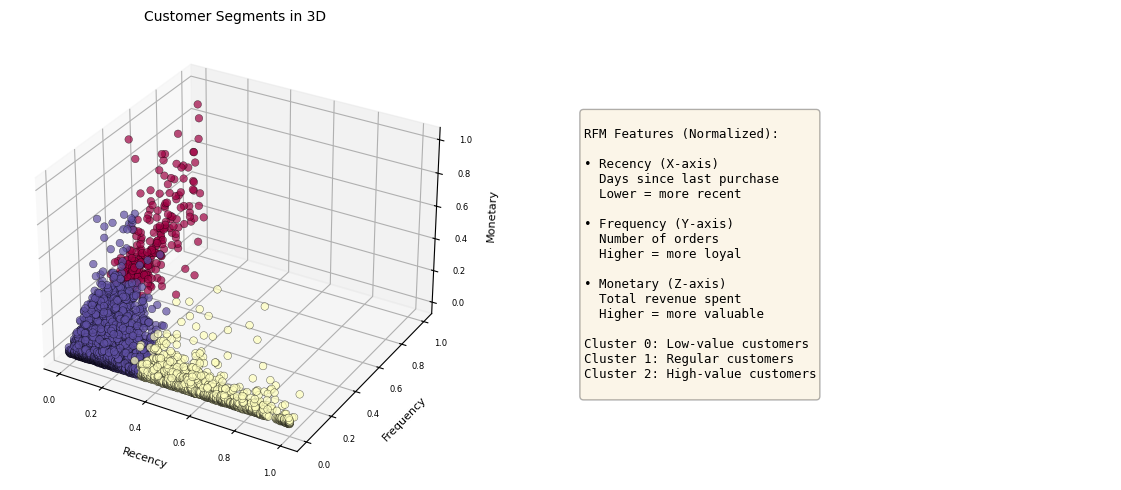

In [17]:
# Cell 12.a: 3D Cluster Visualization and RFM Feature Guide
X3d = X_clean
labels_final = labels_hc

scaler = MinMaxScaler()
X3d_norm = scaler.fit_transform(X3d)

unique_labels = sorted(set(labels_final))
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

fig = plt.figure(figsize=(12, 5))

# LEFT: 3D plot
ax1 = fig.add_subplot(121, projection='3d')
for lab, color in zip(unique_labels, colors):
    mask = labels_final == lab
    ax1.scatter(X3d_norm[mask, 0], X3d_norm[mask, 1], X3d_norm[mask, 2],
                c=[color], label=f"Cluster {lab}", s=30, alpha=0.7,
                edgecolors='k', linewidths=0.3)
ax1.set_xlabel("Recency", fontsize=8)
ax1.set_ylabel("Frequency", fontsize=8)
ax1.set_zlabel("Monetary", fontsize=8)
ax1.set_title("Customer Segments in 3D", fontsize=10)
ax1.tick_params(labelsize=6)

# RIGHT: Text explanation
ax2 = fig.add_subplot(122)
ax2.axis('off')

explanation = """
RFM Features (Normalized):

• Recency (X-axis)
  Days since last purchase
  Lower = more recent

• Frequency (Y-axis)
  Number of orders
  Higher = more loyal

• Monetary (Z-axis)
  Total revenue spent
  Higher = more valuable

Cluster 0: Low-value customers
Cluster 1: Regular customers
Cluster 2: High-value customers
"""

ax2.text(0.1, 0.5, explanation, fontsize=9, family='monospace',
         verticalalignment='center', bbox=dict(boxstyle='round', 
         facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.show()


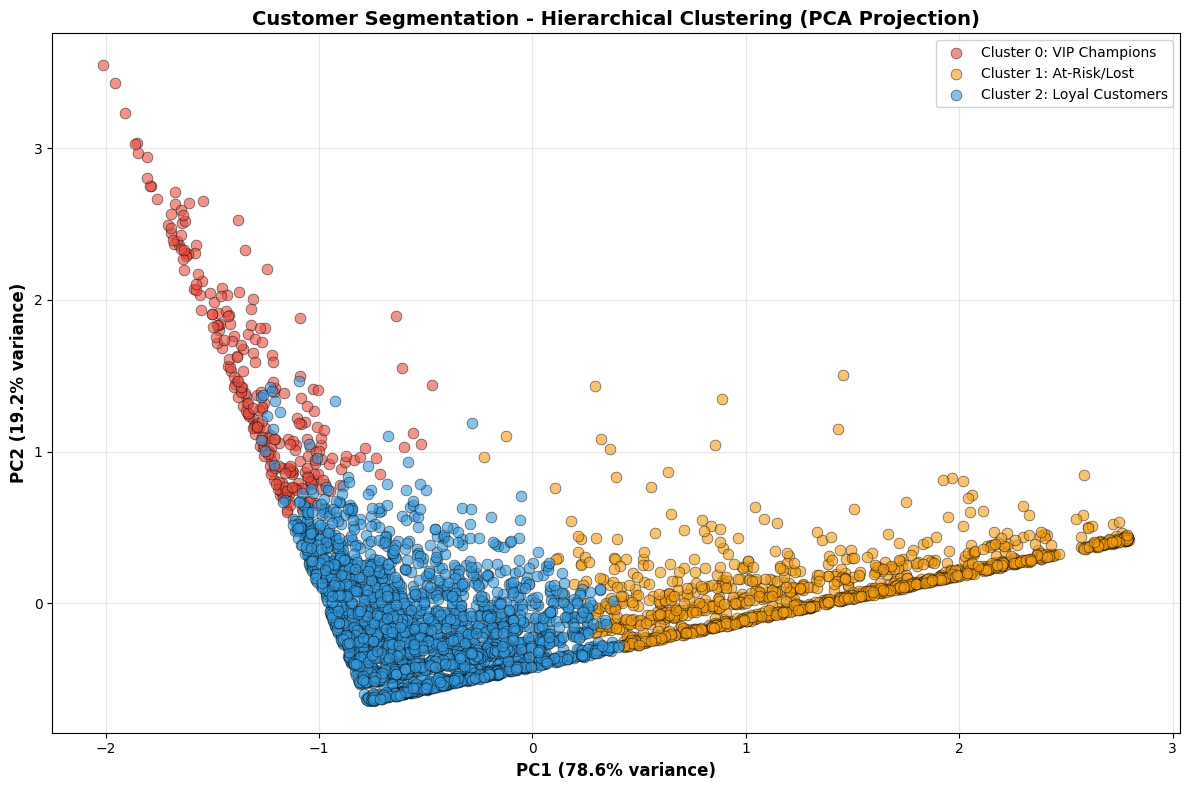


PCA Explained Variance: 97.8%


In [18]:
# Cell 12.b: Visualization - PCA Projection
"""
Visualize customer segments in 2D using PCA.
"""

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# PCA to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_clean)

# Plot
fig, ax = plt.subplots(figsize=(12, 8))

# Define colors and labels
cluster_colors = {0: '#e74c3c', 1: '#f39c12', 2: '#3498db'}
cluster_labels = {0: 'VIP Champions', 1: 'At-Risk/Lost', 2: 'Loyal Customers'}

for cluster_id in sorted(rfm_clean['Cluster'].unique()):
    mask = labels_final == cluster_id
    ax.scatter(
        X_pca[mask, 0],
        X_pca[mask, 1],
        c=cluster_colors[cluster_id],
        label=f"Cluster {cluster_id}: {cluster_labels[cluster_id]}",
        s=60,
        alpha=0.6,
        edgecolors='k',
        linewidths=0.5
    )

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', 
              fontsize=12, fontweight='bold')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', 
              fontsize=12, fontweight='bold')
ax.set_title('Customer Segmentation - Hierarchical Clustering (PCA Projection)', 
             fontsize=14, fontweight='bold')
ax.legend(loc='best', framealpha=0.9, fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nPCA Explained Variance: {pca.explained_variance_ratio_.sum()*100:.1f}%")


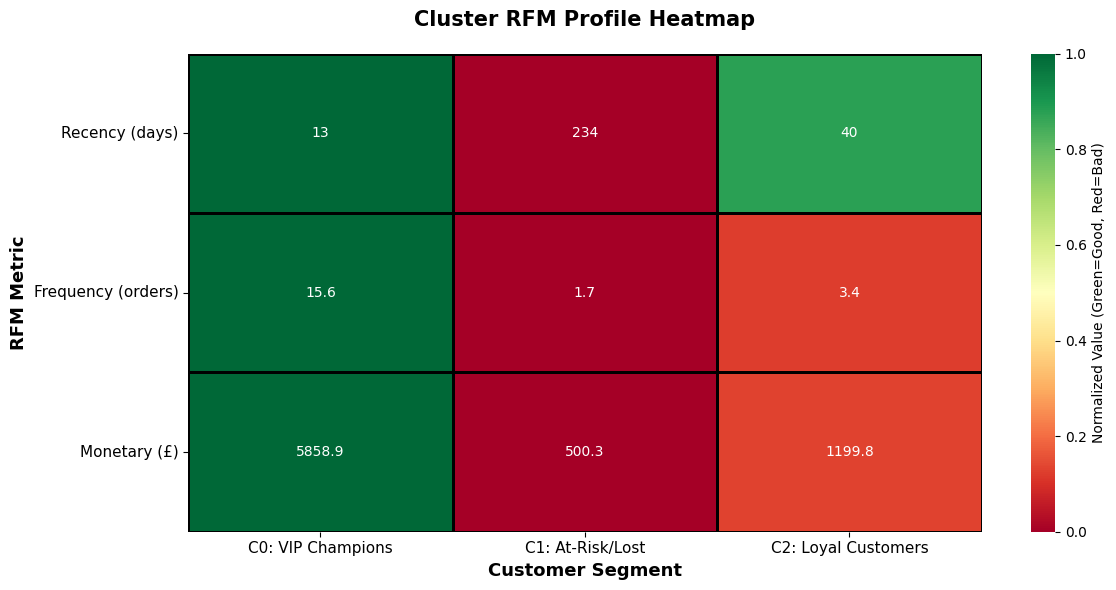


Interpretation (GREEN = Good, RED = Bad):
C0 (VIP Champions):
  • Recency: 13 days → GREEN (recent = good)
  • Frequency: 15.6 orders → GREEN (loyal = good)
  • Monetary: £5,859 → GREEN (valuable = good)

C1 (At-Risk/Lost):
  • Recency: 234 days → RED (dormant = bad)
  • Frequency: 1.7 orders → RED (infrequent = bad)
  • Monetary: £500 → RED (low-value = bad)

C2 (Loyal Customers):
  • Recency: 40 days → YELLOW (medium)
  • Frequency: 3.4 orders → YELLOW (medium)
  • Monetary: £1,200 → YELLOW (medium)


In [19]:
# Cell 13: Cluster Profile Heatmap (IMPROVED)
"""
Visualize RFM characteristics across clusters using heatmap.
Fixed: Inverted Recency so GREEN=good for all metrics.
"""
# Compute mean RFM per cluster
profiles = rfm_clean.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()

# INVERT Recency: lower days → higher score (so GREEN = recent customers)
profiles_viz = profiles.copy()
profiles_viz['Recency'] = profiles['Recency'].max() - profiles['Recency']

# Normalize for color mapping (0-1 scale)
profiles_norm = (profiles_viz - profiles_viz.min()) / (profiles_viz.max() - profiles_viz.min())

# Create heatmap
fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(
    profiles_norm.T,
    annot=profiles.T.round(1),  # Show ORIGINAL values (not inverted)
    fmt='g',
    cmap='RdYlGn',  # GREEN=good, RED=bad (for all metrics now!)
    cbar_kws={'label': 'Normalized Value (Green=Good, Red=Bad)'},
    ax=ax,
    linewidths=2,
    linecolor='black',
    vmin=0,
    vmax=1
)

# Add cluster labels
cluster_labels = ['C0: VIP Champions', 'C1: At-Risk/Lost', 'C2: Loyal Customers']
ax.set_xticklabels(cluster_labels, rotation=0, fontsize=11)
ax.set_yticklabels(['Recency (days)', 'Frequency (orders)', 'Monetary (£)'], 
                    rotation=0, fontsize=11)

ax.set_ylabel('RFM Metric', fontweight='bold', fontsize=13)
ax.set_xlabel('Customer Segment', fontweight='bold', fontsize=13)
ax.set_title('Cluster RFM Profile Heatmap', fontweight='bold', fontsize=15, pad=20)

plt.tight_layout()
plt.show()

print("\nInterpretation (GREEN = Good, RED = Bad):")
print("C0 (VIP Champions):")
print("  • Recency: 13 days → GREEN (recent = good)")
print("  • Frequency: 15.6 orders → GREEN (loyal = good)")
print("  • Monetary: £5,859 → GREEN (valuable = good)")
print("\nC1 (At-Risk/Lost):")
print("  • Recency: 234 days → RED (dormant = bad)")
print("  • Frequency: 1.7 orders → RED (infrequent = bad)")
print("  • Monetary: £500 → RED (low-value = bad)")
print("\nC2 (Loyal Customers):")
print("  • Recency: 40 days → YELLOW (medium)")
print("  • Frequency: 3.4 orders → YELLOW (medium)")
print("  • Monetary: £1,200 → YELLOW (medium)")


In [20]:
# Cell 14: Export Results
"""
Saving final segmented data and summary.
"""

# Save segmented customers
rfm_clean.to_csv('customer_segments_final.csv', index=False)
print("Saved: customer_segments_final.csv")

# Save cluster summary
cluster_summary = rfm_clean.groupby('Cluster').agg({
    'CustomerID': 'count',
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary':
    'mean'
}).round(2)
cluster_summary.columns = ['Customer_Count', 'Avg_Recency', 'Avg_Frequency', 'Avg_Monetary']
cluster_summary['Segment_Label'] = ['VIP Champions', 'At-Risk/Lost', 'Loyal Customers']
cluster_summary.to_csv('cluster_summary.csv')
print("Saved: cluster_summary.csv")

print(" All results exported for business reporting")


Saved: customer_segments_final.csv
Saved: cluster_summary.csv
 All results exported for business reporting


In [21]:
df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))
winner = compare_algorithms(results)


   algorithm  silhouette  davies_bouldin  calinski_harabasz  n_clusters
     K-Means    0.560065        0.676231         6625.69915           3
Hierarchical    0.571193        0.610175         5836.42920           3

ALGORITHM COMPARISON (Multi-Metric)
Algorithm       Silhouette   Davies-Bouldin  Composite 
K-Means         0.5601       0.6762          0.0000    
Hierarchical    0.5712       0.6102          1.0000     ← WINNER
